In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import numpy as np
from loading_utils import parse_vqa_qtypes

/home/alina/miniconda3/envs/babylm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_vqa_superclasses():
    mapping = parse_vqa_qtypes()
    classes = list(set(mapping.values()))
    name_mapping = {}
    for c in classes:
        name_mapping[c.replace(" ","")] = c
    return name_mapping

def load_subtask(task_dir, file, top_k):
    with open(f"{task_dir}/{file}", "rb") as f:
        layer_dict = pickle.load(f)
        top_neurons = []
        for layer, tensors in layer_dict.items():
            top, effects = tensors
            top_new = [f"{layer}_{neuron}" for neuron in top]
            neuron_with_effect = [(neuron, effect) for neuron, effect in zip(top_new, effects)]
            top_neurons.extend(neuron_with_effect)
        top_neurons.sort(key=lambda x: x[1], reverse=True)
        top_neurons = top_neurons[:top_k]
        return top_neurons

In [3]:
tasks = ["blimp", "winoground", "vqa", "mmstar", "ewok"]
task_format = {"blimp": "BLiMP", "winoground": "Winoground", "vqa": "VQA", "mmstar":"MMStar", "ewok":"EWOK"}
mmstar_tasks = {"coarseperception": "Coarse Perception",
                "fine-grainedperception": "Fine-grained Perception",
                "instancereasoning": "Instance Reasoning",
                "logicalreasoning": "Logical Reasoning",
                "math": "Math",
                "science&technology": "Science and Technology"}
winoground_tasks = {"AdjectivalComparisonsandModifications" : "Adjectival Comparisons and Modifications",
"VerbPhrases(IntransitiveandTransitive)" : "Verb Phrases (Intransitive and Transitive)",
"NounPhrasesandModifiers" : "Noun Phrases and Modifiers",
"AlteredPOS" : "Altered POS",
"PrepositionandLocations" : "Preposition and Locations",
"DeterminerandQuantifierRelationships" : "Determiner and Quantifier Relationships",
"ScopeandRelations" : "Scope and Relations",
"NegationandOpposites" : "Negation and Opposites",
"TemporalandSpatialPhrases" : "Temporal and Spatial Phrases"}
ewok_tasks = {"physical-relations": "Physical Relations",
"spatial-relations": "Spatial Relations",
"physical-interactions": "Physical Interactions",
"agent-properties": "Agent Properties",
"material-dynamics": "Material Dynamics",
"social-properties": "Social Properties",
"social-relations": "Social Relations",
"quantitative-properties": "Quantitative Properties",
"social-interactions": "Social Interactions",
"physical-dynamics": "Physical Dynamics",
"material-properties": "Material Properties"
}
blimp_tasks = {"anaphor agreement": "Anaphor Agreement", 
               "binding": "Binding", 
               "determiner noun agreement": "Determiner Noun Agreement", 
               "irregular forms": "Irregular Forms", 
               "s-selection": "S-Selection", 
               "subject verb agreement": "Subject Verb Agreement"
}
vqa_tasks = {"person and object identification": "Person and Object Identification",
"general queries and miscellaneous": "Other",
"action and state": "Action and State",
"color identification": "Color Identification",
"verification and existence": "Verification and Existence",
"identification and classification": "Identification and Classification",
"temporal information": "Temporal Information",
"spatial and positional information": "Spatial and Positional Information",
"reason and purpose": "Reason and Purpose",
"quantity and counting": "Quantity and Counting"}



In [4]:
abbs = {}
with open("subtask_abbr.txt", "r") as f:
    for l in f.readlines():
        parts = l.split("&")
        if len(parts) > 1:
            name = parts[0].strip()
            abb = parts[1].strip()
            abbs[name] = abb

## HEATMAPS

In [6]:
def create_heatmap(tasks, figsize, title, txt_only=False, fontsize=10, exclude=[], dist=(13.5,-13.5),nonewl=False):
    cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

    top_neurons_task = {}
    vqa_names = load_vqa_superclasses()
    task_info = {}
    for task in tasks:
        num_subtasks = 0
        # without img
        task_dir = f"results/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall_noimg/"
        if os.path.isdir(task_dir):
            
            for file in os.listdir(task_dir):   
                if file.endswith(".pkl"):
                    subtask_name = " ".join(file.split('_')[:-2])
                    if task == "vqa":
                        subtask_name = vqa_tasks[vqa_names[subtask_name]]
                    elif task == "mmstar":
                        subtask_name = mmstar_tasks[subtask_name]
                    elif task == "winoground":
                        subtask_name = winoground_tasks[subtask_name]
                    elif task == "ewok":
                        subtask_name = ewok_tasks[subtask_name]
                    elif task == "blimp":
                        subtask_name = blimp_tasks[subtask_name]
                    abb = abbs[subtask_name]
                    subtask_noimg = f"{task}:(txt-only):{abb}"
                    if subtask_name in exclude:
                        continue
                    top_neurons_task[subtask_noimg] = load_subtask(task_dir, file, 100)
                    num_subtasks += 1
            supertask_name = f"{task_format[task]} (text-only)" if nonewl else f"{task_format[task]}\n(text-only)"
            task_info[supertask_name] = num_subtasks
            num_subtasks = 0
        else:
            print(f"didnt find: {task_dir}")
        
        
        # with img
        if not txt_only:
            if task not in ["blimp", "ewok"]:
                task_dir = f"results/top_neurons/{task}/{task}_git_1vd125_s1_e29_nall/"
                if not os.path.isdir(task_dir):
                    print(f"didnt find: {task_dir}")
                    continue
                for file in os.listdir(task_dir):
                    if file.endswith(".pkl"):
                        subtask_name = " ".join(file.split('_')[:-2])
                        if task == "vqa":
                            subtask_name = vqa_tasks[vqa_names[subtask_name]]
                        elif task == "mmstar":
                            subtask_name = mmstar_tasks[subtask_name]
                        elif task == "winoground":
                            subtask_name = winoground_tasks[subtask_name]
                        abb = abbs[subtask_name]
                        subtask = f"{task}:{abb}"
                        if subtask_name in exclude:
                            continue
                        top_neurons_task[subtask] = load_subtask(task_dir, file, 100)
                        num_subtasks += 1
                supertask_name = f"{task_format[task]} (multimodal)" if nonewl else f"{task_format[task]}\n(multimodal)"
                task_info[supertask_name] = num_subtasks


    overlap_newqa = pd.DataFrame(index=top_neurons_task.keys(), columns=top_neurons_task.keys())

    for task_a, neurons_a in top_neurons_task.items():
        for task_b, neurons_b in top_neurons_task.items():
            set_a = set([x[0] for x in neurons_a])
            set_b = set([x[0] for x in neurons_b])
            intersection = set_a.intersection(set_b)
            overlap_amount = len(intersection)
            overlap_newqa.loc[task_a, task_b] = overlap_amount

    overlap_newqa = overlap_newqa.astype(int)

    task_order = list(overlap_newqa.index)
    # remove txt-only label from plot but save task order
    for task in tasks:
        overlap_newqa.columns = overlap_newqa.columns.str.replace(f'{task}:(txt-only):', '', regex=False)
        overlap_newqa.columns = overlap_newqa.columns.str.replace(f'{task}:', '', regex=False)
        overlap_newqa.index = overlap_newqa.index.str.replace(f'{task}:(txt-only):', '', regex=False)
        overlap_newqa.index = overlap_newqa.index.str.replace(f'{task}:', '', regex=False)

    plt.figure(figsize=figsize)
    
    ax = sns.heatmap(overlap_newqa, annot=True, cmap="YlGnBu", fmt="d", annot_kws={"size": fontsize}) # old cmap: "YlGnBu"
    
    # Add vertical and horizontal lines after each task
    current_index = 0
    group_boundaries = []  # to keep track of where the lines are drawn
    for (task, num) in list(task_info.items()):
        current_index += num
        ax.axvline(x=current_index, color='black', linestyle='-', linewidth=1)  # Vertical line
        ax.axhline(y=current_index, color='black', linestyle='-', linewidth=1)  # Horizontal line
        group_boundaries.append(current_index)  # Store the boundary index

    # Adding second outer labeling (grouping the subtasks under each task)
    group_labels = []  # labels to place on the outer x/y-axis
    current_index = 0
    for (task, num) in list(task_info.items()):
        center_pos = current_index + num / 2  # find the middle of the group
        group_labels.append((center_pos, task))  # store the position and task name
        current_index += num

    # Adjust the figure to give space for the outer labels
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)

    # Adding outer task labels on x-axis and y-axis without removing inner labels
    for pos, label in group_labels:
        
        # X-axis outer label
        ax.text(pos, len(overlap_newqa) + dist[0], f"{label}", ha='center', va='center', fontsize=fontsize+2, fontweight='bold')

        # Y-axis outer label
        ax.text(dist[1], pos, f"{label}", ha='center', va='center', fontsize=fontsize+2, fontweight='bold', rotation=90)


    # Keeping the fine-grained inner labels for subtasks
    ax.set_xticks(np.arange(len(overlap_newqa.columns)) + 0.5)
    ax.set_xticklabels(overlap_newqa.columns, rotation=90, ha='center', fontsize=fontsize)

    ax.set_yticks(np.arange(len(overlap_newqa.index)) + 0.5)
    ax.set_yticklabels(overlap_newqa.index, fontsize=fontsize)

    # Draw brackets for groups on both x-axis and y-axis
    current_index = 0
    for i, count in enumerate(list(task_info.values())):
        if i == len(list(task_info)) -1:
            break
        current_index += count

        # Add line on x-axis between subtask labels
        ax.plot([current_index, current_index], [len(overlap_newqa)+dist[0], len(overlap_newqa) + 0], color='black', lw=1, clip_on=False)  # Bottom x-axis

        # Add line on y-axis between subtask labels
        ax.plot([dist[1], 0], [current_index, current_index], color='black', lw=1, clip_on=False)  # Left y-axis

    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xticks(fontsize=fontsize)  # Adjust x-axis font size here
    plt.yticks(fontsize=fontsize)
    plt.show()
    print(task_order)
    return overlap_newqa

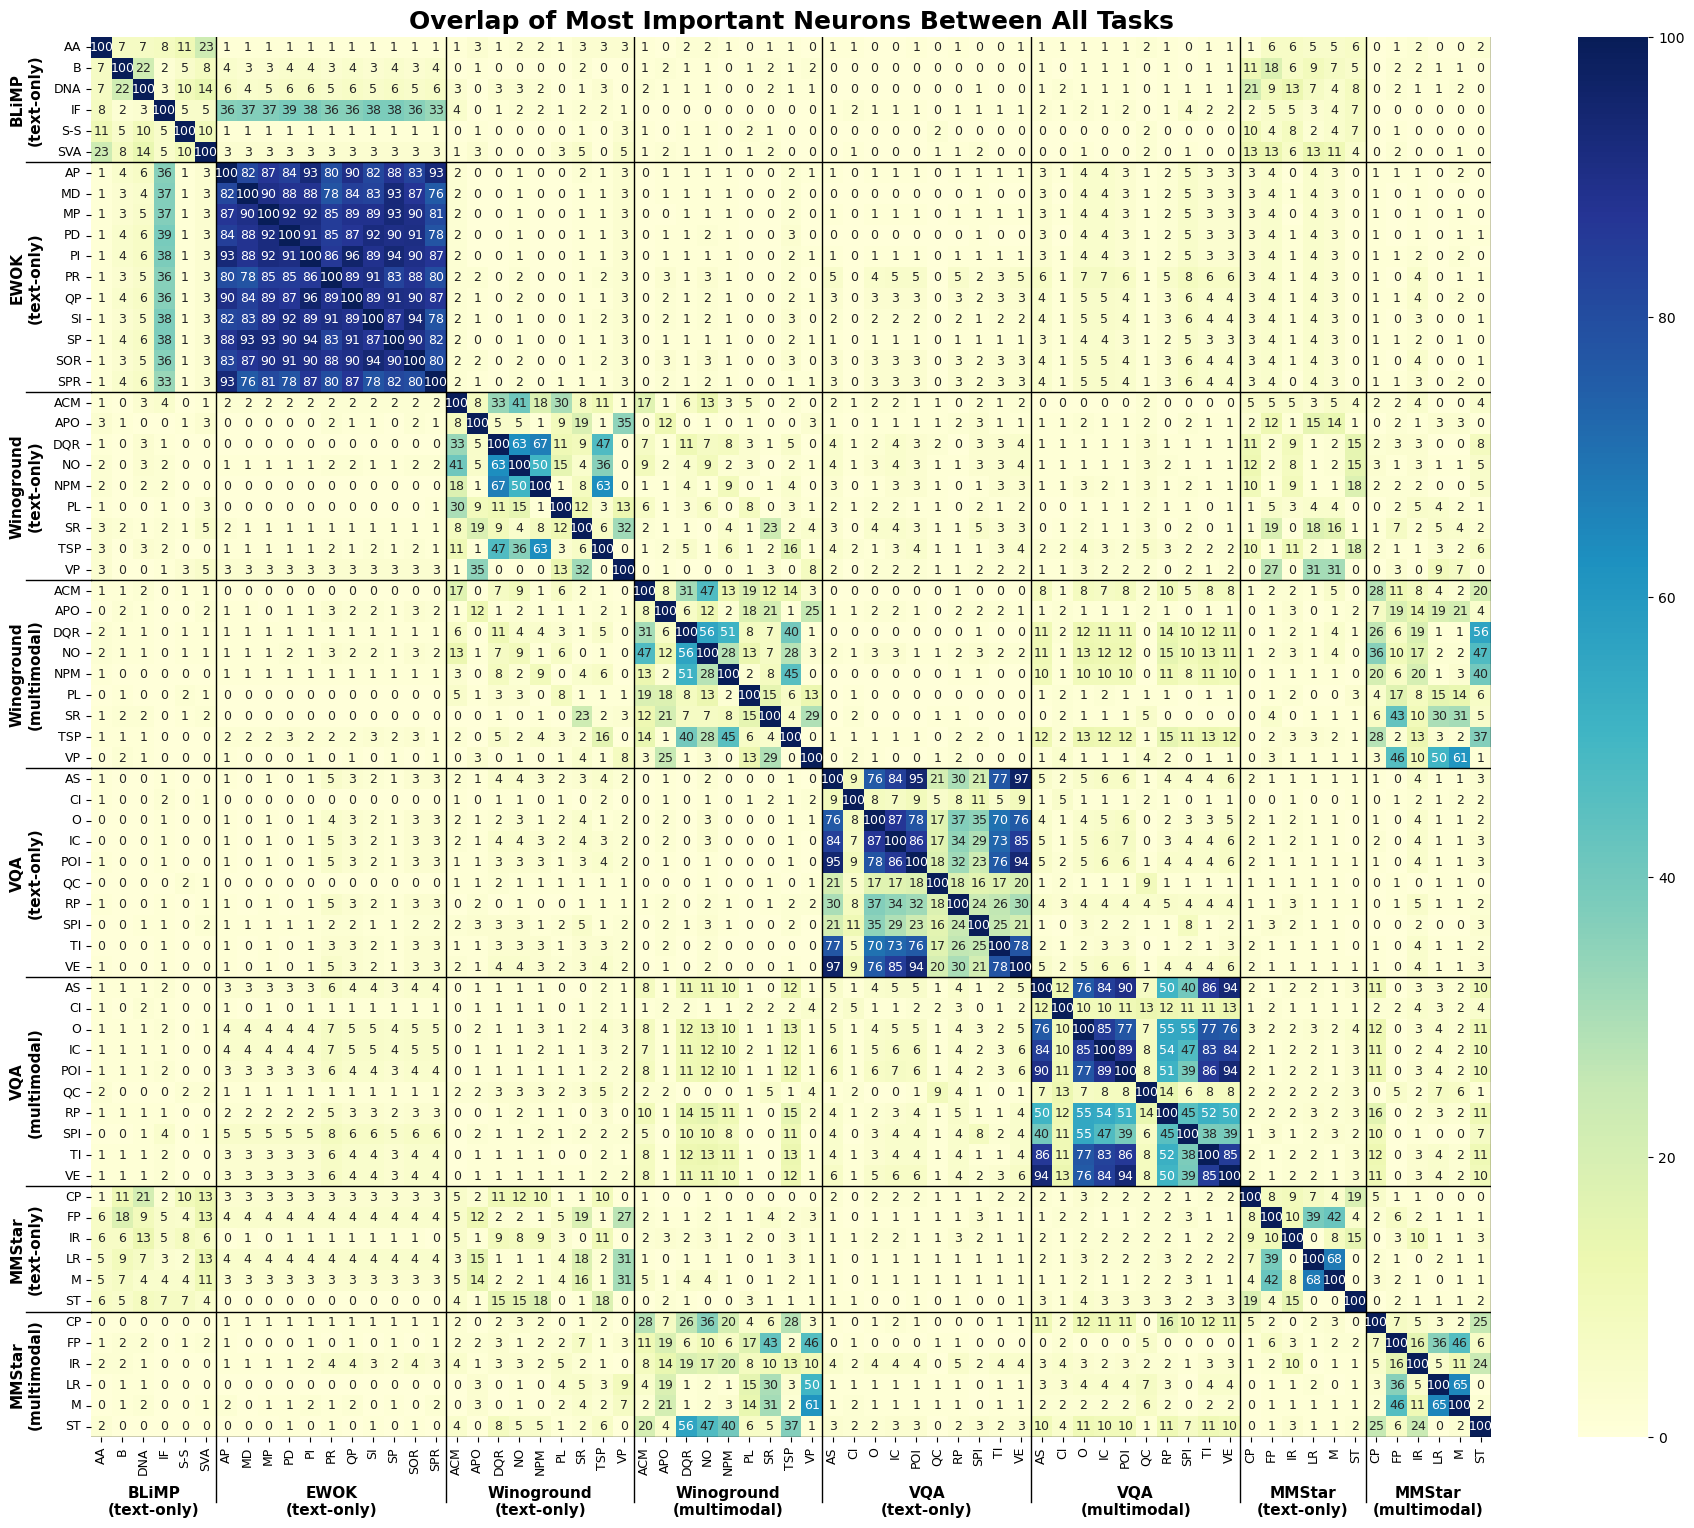

['blimp:(txt-only):AA', 'blimp:(txt-only):B', 'blimp:(txt-only):DNA', 'blimp:(txt-only):IF', 'blimp:(txt-only):S-S', 'blimp:(txt-only):SVA', 'ewok:(txt-only):AP', 'ewok:(txt-only):MD', 'ewok:(txt-only):MP', 'ewok:(txt-only):PD', 'ewok:(txt-only):PI', 'ewok:(txt-only):PR', 'ewok:(txt-only):QP', 'ewok:(txt-only):SI', 'ewok:(txt-only):SP', 'ewok:(txt-only):SOR', 'ewok:(txt-only):SPR', 'winoground:(txt-only):ACM', 'winoground:(txt-only):APO', 'winoground:(txt-only):DQR', 'winoground:(txt-only):NO', 'winoground:(txt-only):NPM', 'winoground:(txt-only):PL', 'winoground:(txt-only):SR', 'winoground:(txt-only):TSP', 'winoground:(txt-only):VP', 'winoground:ACM', 'winoground:APO', 'winoground:DQR', 'winoground:NO', 'winoground:NPM', 'winoground:PL', 'winoground:SR', 'winoground:TSP', 'winoground:VP', 'vqa:(txt-only):AS', 'vqa:(txt-only):CI', 'vqa:(txt-only):O', 'vqa:(txt-only):IC', 'vqa:(txt-only):POI', 'vqa:(txt-only):QC', 'vqa:(txt-only):RP', 'vqa:(txt-only):SPI', 'vqa:(txt-only):TI', 'vqa:(txt-

In [8]:
all_heatmap = create_heatmap(["blimp", "ewok", "winoground", "vqa", "mmstar"], \
                             figsize=(25,20), \
                             title='Overlap of Most Important Neurons Between All Tasks', \
                             fontsize=9, \
                             dist=[3.1, -3.1])


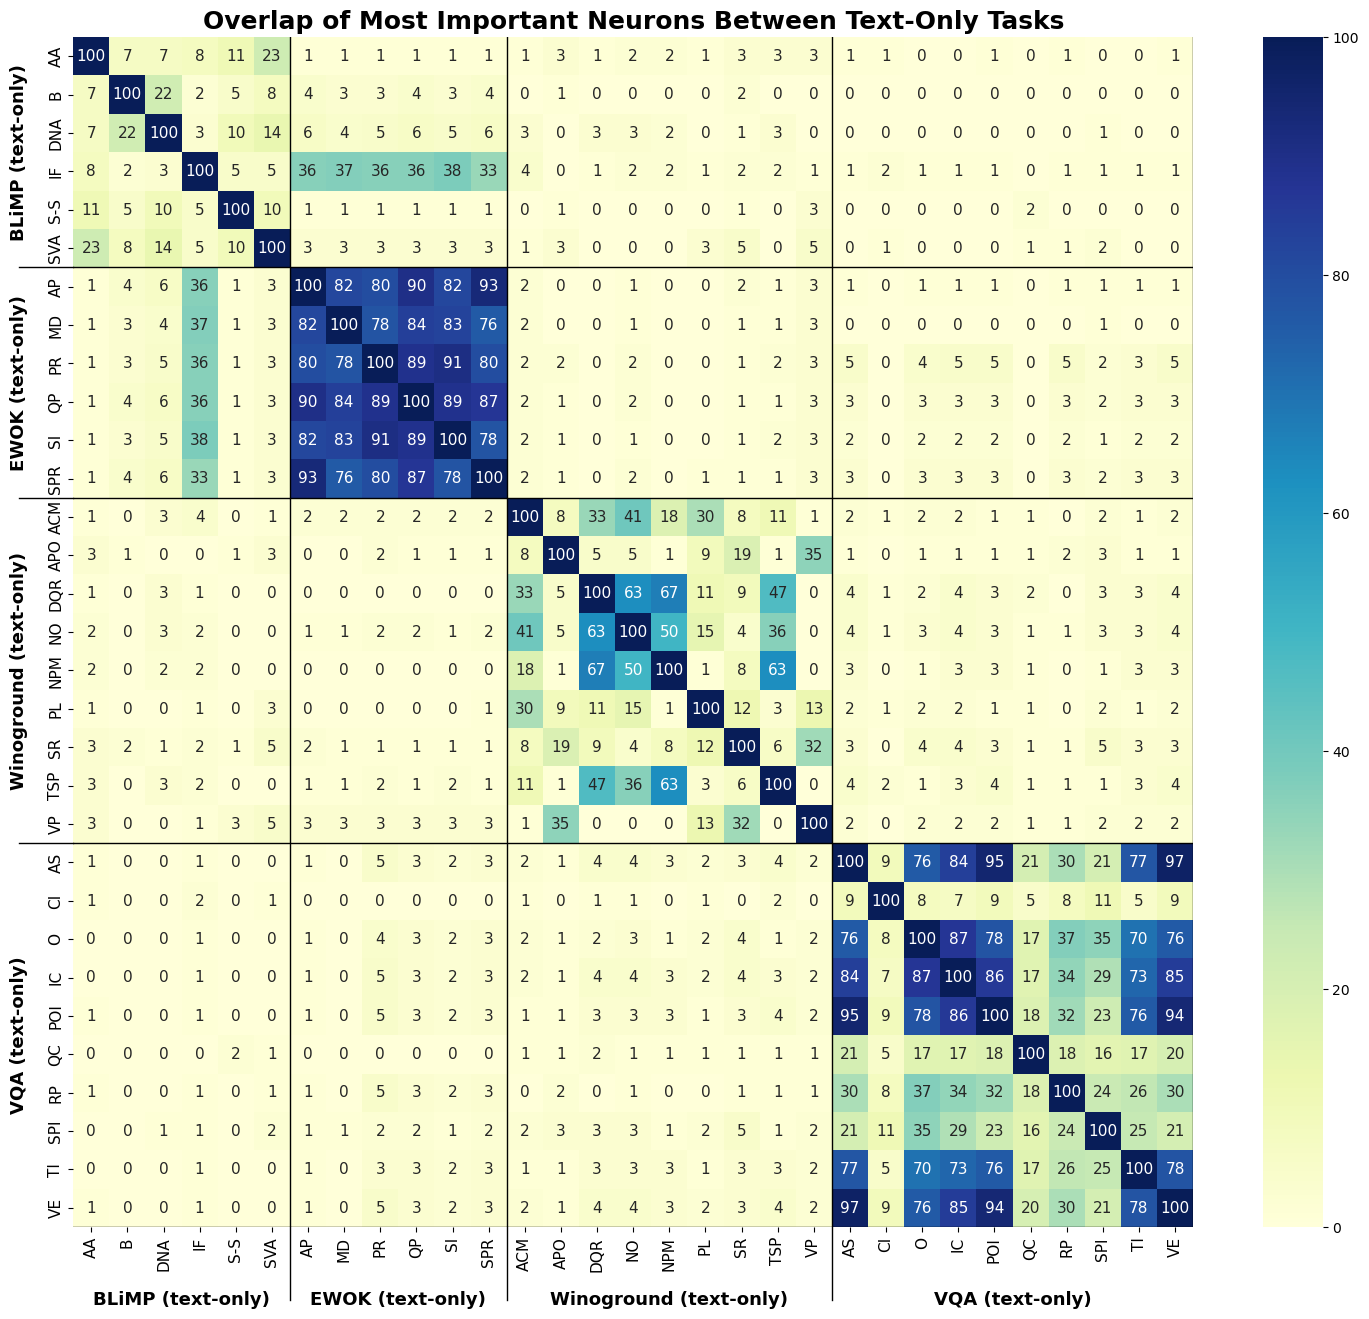

['blimp:(txt-only):AA', 'blimp:(txt-only):B', 'blimp:(txt-only):DNA', 'blimp:(txt-only):IF', 'blimp:(txt-only):S-S', 'blimp:(txt-only):SVA', 'ewok:(txt-only):AP', 'ewok:(txt-only):MD', 'ewok:(txt-only):PR', 'ewok:(txt-only):QP', 'ewok:(txt-only):SI', 'ewok:(txt-only):SPR', 'winoground:(txt-only):ACM', 'winoground:(txt-only):APO', 'winoground:(txt-only):DQR', 'winoground:(txt-only):NO', 'winoground:(txt-only):NPM', 'winoground:(txt-only):PL', 'winoground:(txt-only):SR', 'winoground:(txt-only):TSP', 'winoground:(txt-only):VP', 'vqa:(txt-only):AS', 'vqa:(txt-only):CI', 'vqa:(txt-only):O', 'vqa:(txt-only):IC', 'vqa:(txt-only):POI', 'vqa:(txt-only):QC', 'vqa:(txt-only):RP', 'vqa:(txt-only):SPI', 'vqa:(txt-only):TI', 'vqa:(txt-only):VE']


In [9]:
text_heatmap = create_heatmap(["blimp", "ewok", "winoground", "vqa"], \
                               figsize=(20,17), \
                               title='Overlap of Most Important Neurons Between Text-Only Tasks', \
                               txt_only=True, \
                               fontsize=11, \
                               exclude=["Material Properties", "Physical Dynamics", "Social Properties", "Physical Interactions", "Social Relations"], \
                               dist=[1.9, -1.5], \
                               nonewl=True)

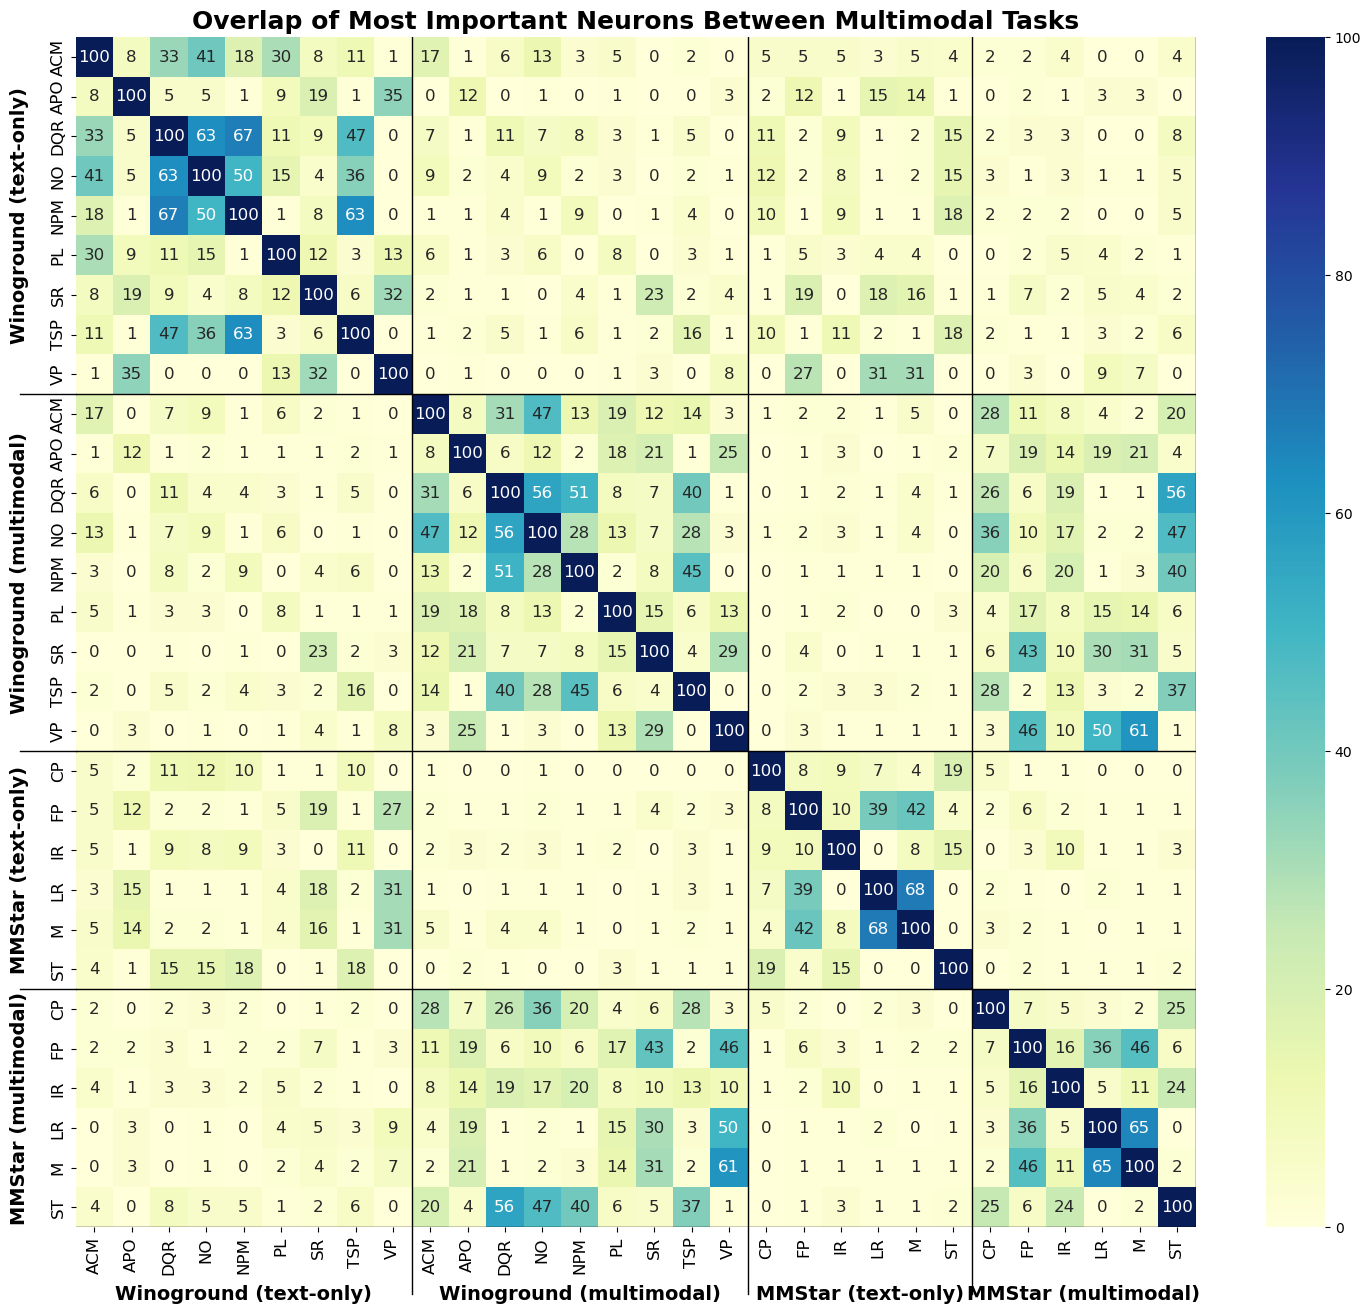

['winoground:(txt-only):ACM', 'winoground:(txt-only):APO', 'winoground:(txt-only):DQR', 'winoground:(txt-only):NO', 'winoground:(txt-only):NPM', 'winoground:(txt-only):PL', 'winoground:(txt-only):SR', 'winoground:(txt-only):TSP', 'winoground:(txt-only):VP', 'winoground:ACM', 'winoground:APO', 'winoground:DQR', 'winoground:NO', 'winoground:NPM', 'winoground:PL', 'winoground:SR', 'winoground:TSP', 'winoground:VP', 'mmstar:(txt-only):CP', 'mmstar:(txt-only):FP', 'mmstar:(txt-only):IR', 'mmstar:(txt-only):LR', 'mmstar:(txt-only):M', 'mmstar:(txt-only):ST', 'mmstar:CP', 'mmstar:FP', 'mmstar:IR', 'mmstar:LR', 'mmstar:M', 'mmstar:ST']


In [10]:
multimodal_heatmap = create_heatmap(["winoground", "mmstar"], \
                                    figsize=(20,17), \
                                    title='Overlap of Most Important Neurons Between Multimodal Tasks', \
                                    txt_only=False, \
                                    fontsize=12, \
                                    dist=[1.7, -1.5], \
                                    nonewl=True)